# Deep Learning Anomaly Detection - Analysis Notebook

This notebook provides comprehensive analysis of the Deep Learning model for SOC log anomaly detection.

## Contents:
1. **Model Architecture Analysis**
2. **Training Performance Visualization**
3. **Embedding Analysis**
4. **Anomaly Score Analysis**
5. **Model Comparison (LSTM vs Isolation Forest)**
6. **Case Studies**

In [3]:
# Import libraries
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch # type: ignore  # noqa: F401
import seaborn as sns  # type: ignore  # noqa: F401

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('default')
        print("Using default matplotlib style")

%matplotlib inline

print("Libraries imported successfully")

Libraries imported successfully


## 1. Model Architecture Analysis

In [5]:
# Load model and analyze architecture
from model.deeplog_lstm import DeepLogLSTM
from model.model_analysis import print_model_summary, count_parameters

# Load checkpoint
model_path = "../model/model.pth"
ckpt = torch.load(model_path, map_location='cpu')

num_labels = ckpt['num_labels']
window_size = ckpt['window_size']
embedding_dim = ckpt.get('embedding_dim', 16)
hidden_size = ckpt.get('hidden_size', 128)
num_layers = ckpt.get('num_layers', 1)

print(f" Model Configuration:")
print(f"   - Number of log templates: {num_labels}")
print(f"   - Window size: {window_size}")
print(f"   - Embedding dimension: {embedding_dim}")
print(f"   - Hidden size: {hidden_size}")
print(f"   - LSTM layers: {num_layers}")

# Create model
model = DeepLogLSTM(
    num_labels=num_labels,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    num_layers=num_layers
)
model.load_state_dict(ckpt['model_state_dict'])

# Print detailed summary
print_model_summary(model, input_size=(64, window_size))

 Model Configuration:
   - Number of log templates: 28
   - Window size: 5
   - Embedding dimension: 16
   - Hidden size: 128
   - LSTM layers: 1
DEEP LEARNING MODEL SUMMARY

[ARCHITECTURE]
DeepLogLSTM(
  (embedding): Embedding(28, 16)
  (lstm): LSTM(16, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=28, bias=True)
)

[PARAMETERS]
  Total parameters      : 78,812
  Trainable parameters : 78,812
  Non-trainable         : 0

[MODEL SIZE]
  Estimated size       : 0.30 MB

[LAYER BREAKDOWN]
  embedding            : 448 parameters
  lstm                 : 74,752 parameters
  fc                   : 3,612 parameters

[FORWARD PASS TEST]
  Error: index out of range in self


## 2. Training Performance Visualization

In [13]:
# Load training history
history_path = "../model/training_history.json"

if os.path.exists(history_path):
    with open(history_path, 'r') as f:
        history = json.load(f)
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Create comprehensive training plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Loss curves
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2, marker='o')
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s')
    axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2, marker='o')
    axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2, marker='s')
    axes[0, 1].set_title('Training & Validation Accuracy (Top-1)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Top-k Accuracy
    axes[1, 0].plot(epochs, history['train_topk_acc'], 'b-', label='Training Top-5 Acc', linewidth=2, marker='o')
    axes[1, 0].plot(epochs, history['val_topk_acc'], 'r-', label='Validation Top-5 Acc', linewidth=2, marker='s')
    axes[1, 0].set_title('Top-5 Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Top-5 Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning progress (loss reduction)
    initial_loss = history['train_loss'][0]
    final_loss = history['train_loss'][-1]
    loss_reduction = ((initial_loss - final_loss) / initial_loss) * 100
    
    axes[1, 1].bar(['Initial', 'Final'], [initial_loss, final_loss], color=['red', 'green'], alpha=0.7)
    axes[1, 1].set_title(f'Loss Reduction: {loss_reduction:.1f}%', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Deep Learning Model Training Performance', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n Training Summary:")
    print(f"   - Final Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"   - Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"   - Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"   - Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
    print(f"   - Loss Reduction: {loss_reduction:.1f}%")
else:
    print(" Training history not found. Run training first.")

 Training history not found. Run training first.


[+] Embedding visualization saved to ../data/results/embeddings_tsne.png
Embedding visualization (t-SNE) saved


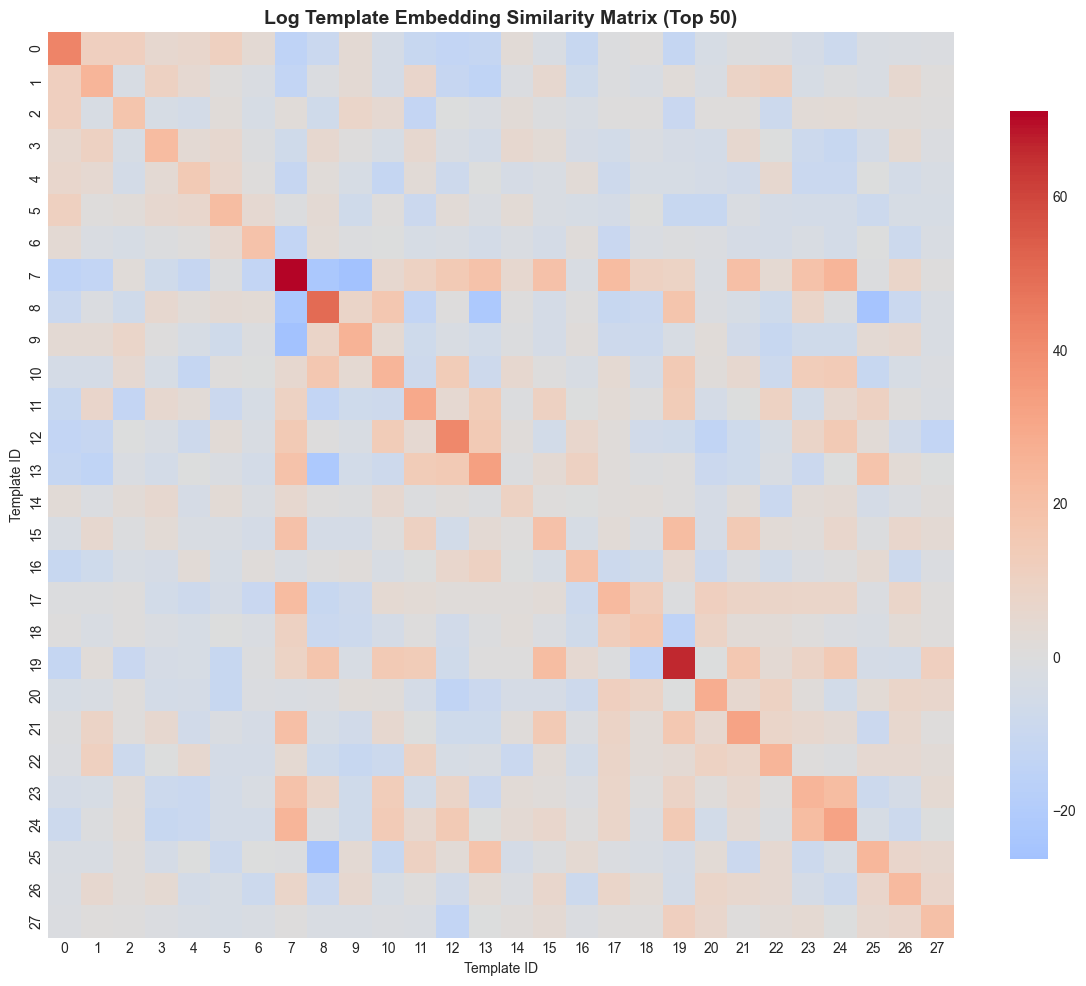

Embedding similarity analysis completed


In [8]:
# Visualize learned embeddings
from model.model_analysis import visualize_embeddings

# Visualize embeddings using t-SNE
try:
    visualize_embeddings(
        model,
        num_labels=num_labels,
        save_path="../data/results/embeddings_tsne.png",
        method='tsne',
        top_n=min(100, num_labels)
    )
    print("Embedding visualization (t-SNE) saved")
except Exception as e:
    print(f"t-SNE visualization failed: {e}")
    print("Trying PCA instead...")
    visualize_embeddings(
        model,
        num_labels=num_labels,
        save_path="../data/results/embeddings_pca.png",
        method='pca',
        top_n=min(100, num_labels)
    )
    print("Embedding visualization (PCA) saved")

# Analyze embedding similarity
embeddings = model.embedding.weight.data.cpu().numpy()
similarity_matrix = np.dot(embeddings, embeddings.T)

plt.figure(figsize=(12, 10))
# Check if seaborn is available (handle case where SEABORN_AVAILABLE not defined)
try:
    import seaborn as sns
    sns.heatmap(similarity_matrix[:50, :50], cmap='coolwarm', center=0, 
                square=True, cbar_kws={"shrink": 0.8})
except (ImportError, NameError):
    # Fallback to matplotlib
    im = plt.imshow(similarity_matrix[:50, :50], cmap='coolwarm', aspect='auto', 
                    interpolation='nearest', vmin=-1, vmax=1)
    plt.colorbar(im, shrink=0.8)
plt.title('Log Template Embedding Similarity Matrix (Top 50)', fontsize=14, fontweight='bold')
plt.xlabel('Template ID')
plt.ylabel('Template ID')
plt.tight_layout()
plt.show()

print("Embedding similarity analysis completed")

## 4. Anomaly Score Analysis

LSTM Scores Statistics:
   - Total samples: 103,195
   - Mean: 0.1866
   - Std: 0.9018
   - Min: -0.0000
   - Max: 54.7085
   - Median: 0.0376
   - 95th percentile: 0.0926
   - 99th percentile: 5.2585
   - Perplexity: 1.2051


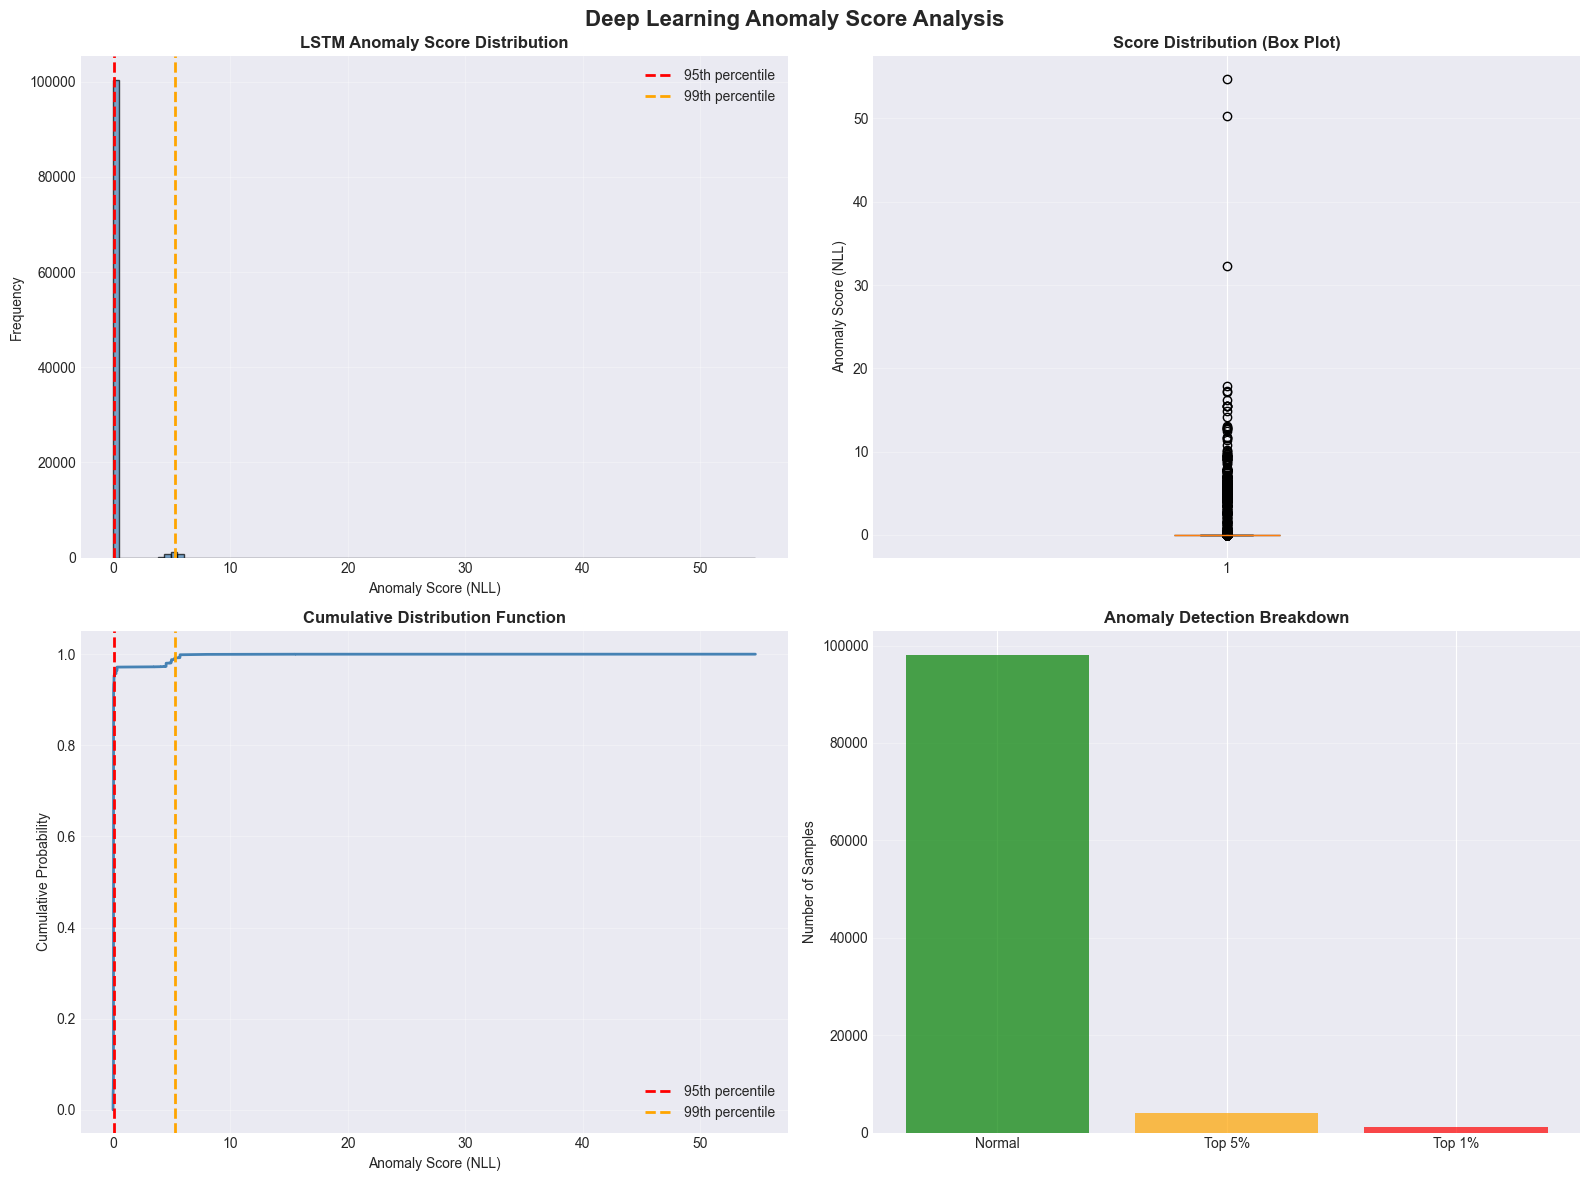


🔍 Anomaly Detection Summary:
   - Top 5% anomalies: 5,183 (5.02%)
   - Top 1% anomalies: 1,221 (1.18%)


In [9]:
# Load anomaly scores
lstm_scores_path = "../data/sequences/lstm_scores.pkl"
if_scores_path = "../data/sequences/if_scores.pkl"

with open(lstm_scores_path, "rb") as f:
    lstm_scores = np.array(pickle.load(f))

print(f"LSTM Scores Statistics:")
print(f"   - Total samples: {len(lstm_scores):,}")
print(f"   - Mean: {lstm_scores.mean():.4f}")
print(f"   - Std: {lstm_scores.std():.4f}")
print(f"   - Min: {lstm_scores.min():.4f}")
print(f"   - Max: {lstm_scores.max():.4f}")
print(f"   - Median: {np.median(lstm_scores):.4f}")
print(f"   - 95th percentile: {np.percentile(lstm_scores, 95):.4f}")
print(f"   - 99th percentile: {np.percentile(lstm_scores, 99):.4f}")

# Calculate perplexity
perplexity = np.exp(np.mean(lstm_scores))
print(f"   - Perplexity: {perplexity:.4f}")

# Score distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram
axes[0, 0].hist(lstm_scores, bins=100, alpha=0.7, edgecolor='black', color='steelblue')
axes[0, 0].axvline(np.percentile(lstm_scores, 95), color='red', linestyle='--', 
                   linewidth=2, label='95th percentile')
axes[0, 0].axvline(np.percentile(lstm_scores, 99), color='orange', linestyle='--', 
                   linewidth=2, label='99th percentile')
axes[0, 0].set_xlabel('Anomaly Score (NLL)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('LSTM Anomaly Score Distribution', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
axes[0, 1].boxplot(lstm_scores, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='steelblue', alpha=0.7))
axes[0, 1].set_ylabel('Anomaly Score (NLL)')
axes[0, 1].set_title('Score Distribution (Box Plot)', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Cumulative distribution
sorted_scores = np.sort(lstm_scores)
cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
axes[1, 0].plot(sorted_scores, cumulative, linewidth=2, color='steelblue')
axes[1, 0].axvline(np.percentile(lstm_scores, 95), color='red', linestyle='--', 
                   linewidth=2, label='95th percentile')
axes[1, 0].axvline(np.percentile(lstm_scores, 99), color='orange', linestyle='--', 
                   linewidth=2, label='99th percentile')
axes[1, 0].set_xlabel('Anomaly Score (NLL)')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].set_title('Cumulative Distribution Function', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Tail analysis
tail_95 = lstm_scores >= np.percentile(lstm_scores, 95)
tail_99 = lstm_scores >= np.percentile(lstm_scores, 99)

axes[1, 1].bar(['Normal', 'Top 5%', 'Top 1%'], 
               [len(lstm_scores) - tail_95.sum(), 
                tail_95.sum() - tail_99.sum(), 
                tail_99.sum()],
               color=['green', 'orange', 'red'], alpha=0.7)
axes[1, 1].set_ylabel('Number of Samples')
axes[1, 1].set_title('Anomaly Detection Breakdown', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Deep Learning Anomaly Score Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n🔍 Anomaly Detection Summary:")
print(f"   - Top 5% anomalies: {tail_95.sum():,} ({tail_95.sum()/len(lstm_scores)*100:.2f}%)")
print(f"   - Top 1% anomalies: {tail_99.sum():,} ({tail_99.sum()/len(lstm_scores)*100:.2f}%)")

## 5. Model Comparison: LSTM vs Isolation Forest

 Model Comparison Metrics:
   - Spearman Correlation: 0.0141 (p=0.0000)
   - Top-5159 Jaccard Index: 0.0492
   - Top-5159 Overlap: 484/5159 (9.4%)


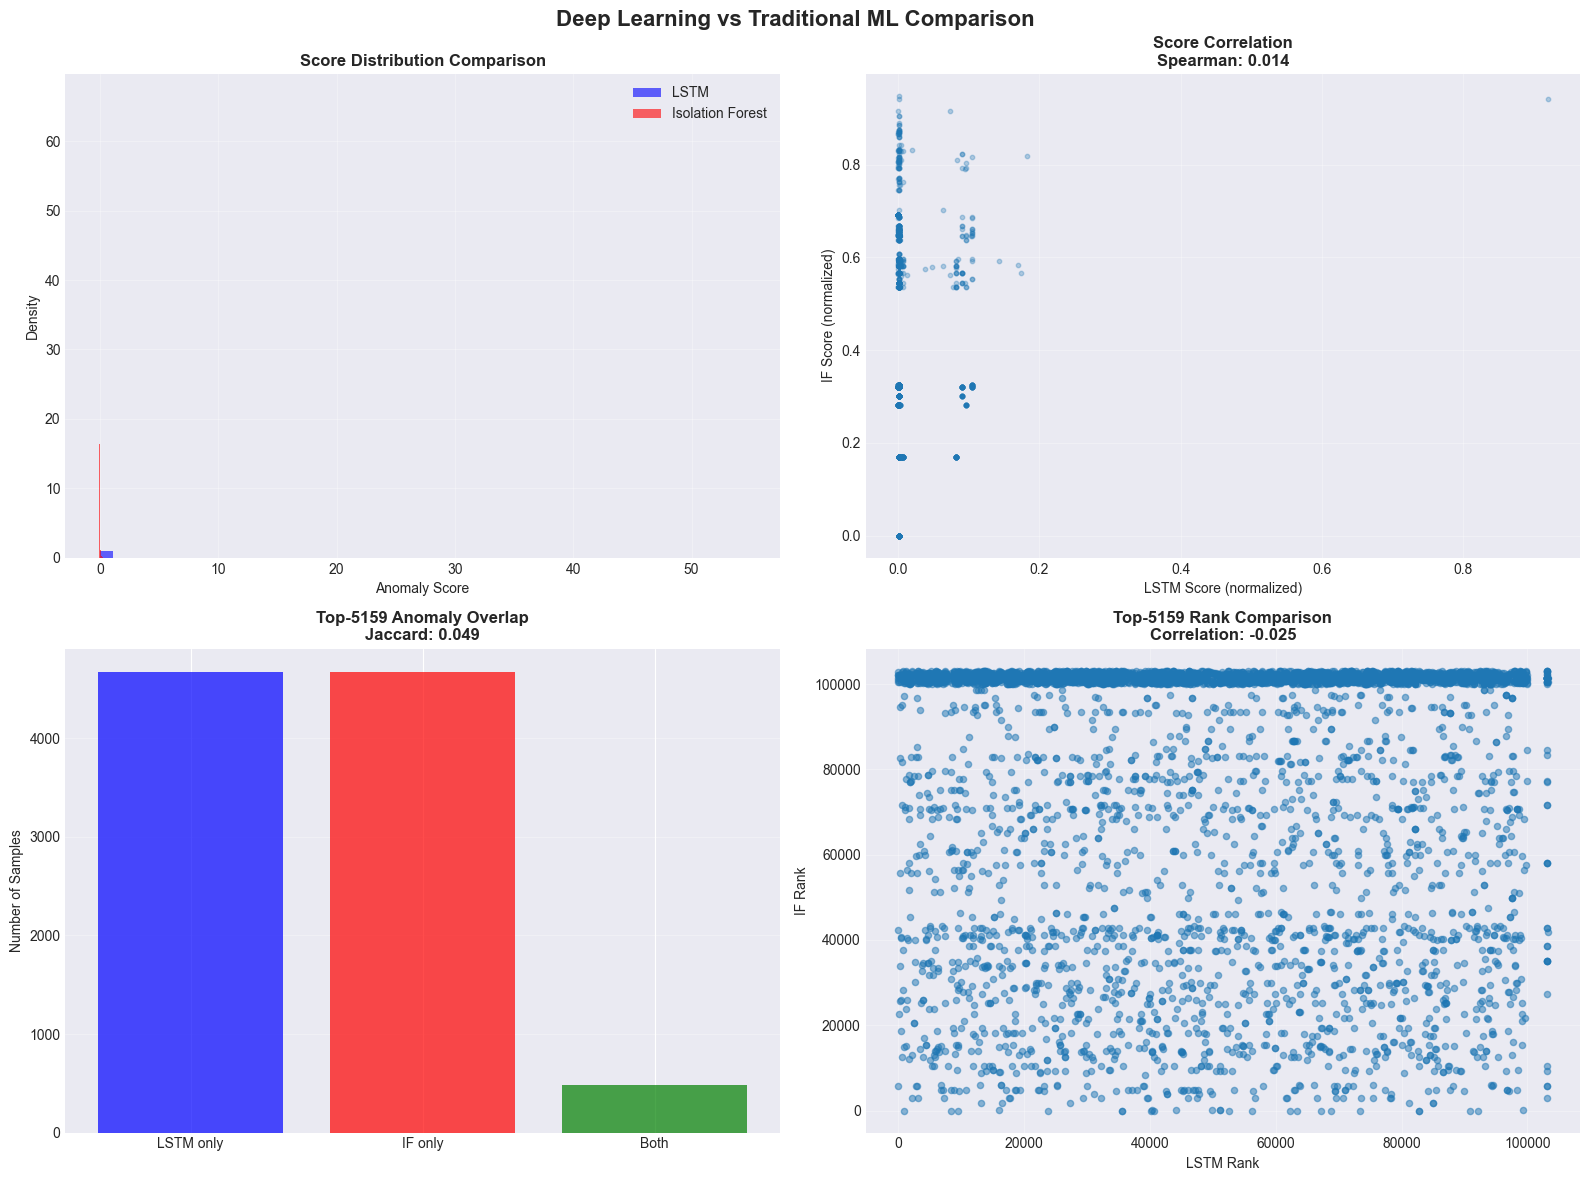


 Insight: LSTM and IF capture different anomaly signals - Deep Learning provides complementary detection!


In [10]:
# Compare LSTM with Isolation Forest baseline
if os.path.exists(if_scores_path):
    with open(if_scores_path, "rb") as f:
        if_scores = np.array(pickle.load(f))
    
    from scipy.stats import spearmanr
    
    # Normalize scores for comparison
    def normalize(s):
        return (s - s.min()) / (s.max() - s.min() + 1e-8)
    
    lstm_norm = normalize(lstm_scores)
    if_norm = normalize(if_scores)
    
    # Calculate correlation
    spearman_corr, spearman_p = spearmanr(lstm_scores, if_scores)
    
    # Top-k overlap
    k = int(len(lstm_scores) * 0.05)
    lstm_topk = set(np.argsort(-lstm_scores)[:k])
    if_topk = set(np.argsort(-if_scores)[:k])
    intersection = lstm_topk & if_topk
    jaccard = len(intersection) / len(lstm_topk | if_topk)
    
    print(f" Model Comparison Metrics:")
    print(f"   - Spearman Correlation: {spearman_corr:.4f} (p={spearman_p:.4f})")
    print(f"   - Top-{k} Jaccard Index: {jaccard:.4f}")
    print(f"   - Top-{k} Overlap: {len(intersection)}/{k} ({len(intersection)/k*100:.1f}%)")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Score distribution comparison
    axes[0, 0].hist(lstm_scores, bins=50, alpha=0.6, label='LSTM', color='blue', density=True)
    axes[0, 0].hist(if_scores, bins=50, alpha=0.6, label='Isolation Forest', color='red', density=True)
    axes[0, 0].set_xlabel('Anomaly Score')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Score Distribution Comparison', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Scatter plot
    sample_idx = np.random.choice(len(lstm_scores), size=min(5000, len(lstm_scores)), replace=False)
    axes[0, 1].scatter(lstm_norm[sample_idx], if_norm[sample_idx], alpha=0.3, s=10)
    axes[0, 1].set_xlabel('LSTM Score (normalized)')
    axes[0, 1].set_ylabel('IF Score (normalized)')
    axes[0, 1].set_title(f'Score Correlation\nSpearman: {spearman_corr:.3f}', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Top-k comparison
    topk_data = {
        'LSTM only': len(lstm_topk - if_topk),
        'IF only': len(if_topk - lstm_topk),
        'Both': len(intersection)
    }
    axes[1, 0].bar(topk_data.keys(), topk_data.values(), 
                   color=['blue', 'red', 'green'], alpha=0.7)
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].set_title(f'Top-{k} Anomaly Overlap\nJaccard: {jaccard:.3f}', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Rank comparison
    lstm_ranks = np.argsort(-lstm_scores)
    if_ranks = np.argsort(-if_scores)
    rank_corr = np.corrcoef(lstm_ranks, if_ranks)[0, 1]
    
    axes[1, 1].scatter(lstm_ranks[:k], if_ranks[:k], alpha=0.5, s=20)
    axes[1, 1].set_xlabel('LSTM Rank')
    axes[1, 1].set_ylabel('IF Rank')
    axes[1, 1].set_title(f'Top-{k} Rank Comparison\nCorrelation: {rank_corr:.3f}', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Deep Learning vs Traditional ML Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    if jaccard < 0.5:
        print("\n Insight: LSTM and IF capture different anomaly signals - Deep Learning provides complementary detection!")
    else:
        print("\n Insight: LSTM and IF largely agree on anomalous samples.")
else:
    print(" Isolation Forest scores not found.")

In [11]:
# Analyze high-anomaly sequences
sequences_path = "../data/sequences/sequences.pkl"
event_mapping_path = "../data/sequences/event_mapping.json"

with open(sequences_path, "rb") as f:
    sequences = pickle.load(f)

with open(event_mapping_path, "r") as f:
    event_mapping = json.load(f)

idx2event = event_mapping['idx2event']
event2idx = event_mapping['event2idx']

# Find top anomalies
top_n = 10
top_anomaly_indices = np.argsort(-lstm_scores)[:top_n]

print(f" Top {top_n} Anomalous Sequences Detected by Deep Learning Model:\n")
print("=" * 80)

for i, idx in enumerate(top_anomaly_indices, 1):
    seq = sequences[idx]
    score = lstm_scores[idx]
    
    print(f"\n[Case {i}] Index: {idx}, Anomaly Score: {score:.4f}")
    print(f"Sequence: {seq}")
    print(f"Sequence Length: {len(seq)}")
    
    # Show sequence pattern
    if len(seq) <= 20:
        print(f"Pattern: {' -> '.join(map(str, seq))}")
    else:
        print(f"Pattern (first 10): {' -> '.join(map(str, seq[:10]))} ...")

print("\n" + "=" * 80)
print("Analysis completed!")

 Top 10 Anomalous Sequences Detected by Deep Learning Model:


[Case 1] Index: 63861, Anomaly Score: 54.7085
Sequence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 0, 1]
Sequence Length: 20
Pattern: 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 2 -> 5 -> 0 -> 0 -> 1

[Case 2] Index: 58019, Anomaly Score: 50.3010
Sequence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3, 6, 3]
Sequence Length: 20
Pattern: 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 5 -> 3 -> 6 -> 3

[Case 3] Index: 25273, Anomaly Score: 32.2933
Sequence: [0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 4, 1]
Sequence Length: 20
Pattern: 0 -> 4 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 0 -> 4 -> 0 -> 2 -> 0 -> 0 -> 4 -> 1

[Case 4] Index: 103185, Anomaly Score: 17.8205
Sequence: [20, 9, 27, 19, 9, 20, 18, 27, 9, 27, 18, 9, 11, 17, 22, 25, 25, 9, 18, 16]
Sequence Length: 20
Pattern: 20 -> 9 -> 27 -> 19 -> 9 -> 20 -> 18 -> 27 